In [1]:
!wget --no-check-certificate 'https://cdn.discordapp.com/attachments/1209871752134529066/1249007689183268864/reduced_dataset.zip?ex=6676e00e&is=66758e8e&hm=ad151f919e12fa80c08cbcb693072d4aa9cf65f19e810a70ff43ada89864fd01&' -O ../reduced_dataset.zip
!unzip ../reduced_dataset.zip
!mv reduced_dataset ..

Output streaming troncato alle ultime 5000 righe.
  inflating: reduced_dataset/dataset/audio/right/b737ee80_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/b7a0754f_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b83c1acf_nohash_4.wav  
  inflating: reduced_dataset/dataset/audio/right/b8c48ffb_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/b93528e3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b959cd0c_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b97c9f77_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/bcdaa7a9_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/bd11a2e7_nohash_2.wav  
 

# Modello convolutivo avanzato

In questo notebook implementeremo un'architettura affermata nell'ambito del riconoscimento vocale, la **VggVox**.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.fftpack as scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# per il modello con estensione .onnx
import onnxruntime as rt
import tf2onnx
import onnx

## Importazione funzioni
In aggiunta alla classe per la conversione del dataset, ci serviremo delle seguenti funzioni:
- `convert_history_to_csv` - salva l'history dell'addestramento in un csv
- `convert_model_to_onnx` - converte il miglior modello **.keras** in **.onnx**
- `create_train_val_plot` - visualizza l'andamento dell'accuratezza e della perdita durante l'addestramento
- `evaluate_onnx_model` - valuta il modello sui dati di test con il modello **.onnx**
- `create_distribution_plot` - visualizza la distribuzione di accuratezza delle classi su un'immagine casuale

Sia la classe che le funzioni appena citate sono già conosciute dai notebook precedenti, perciò non ci soffermeremo nel dettaglio su di esse.

In [6]:
def convert_history_to_csv(model_history):
    # converto la history del dataframe in un dataframe pandas
    model_history_df = pd.DataFrame(model_history.history)
    # cambio il nome dell'indice e lo imposto a partire da 1
    model_history_df.index = range(1, len(model_history_df) + 1)
    model_history_df.index.name = "epochs"

    return model_history_df

def convert_model_to_onnx(model_path, input_shape):
    model = tf.keras.models.load_model(model_path)

    onnx_path = model_path.split(".")[:-1] + ["onnx"]
    onnx_path = ".".join(onnx_path)

    input_signature = [tf.TensorSpec((None, *input_shape), tf.float32, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    onnx.save(onnx_model, onnx_path)

def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch mi crea problemi, perciò lo risolvo togliendoli
    test_ds = test_ds.unbatch()

    # carico il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)

    # trasformo il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds], dtype=np.float32)
    labels_np = np.array([label.numpy() for _, label in test_ds])

    # eseguo le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottengo la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computo la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampo l'accuratezza
    print(f"Accuratezza: {accuracy:.3f}")

def create_distribution_plot(model, audio, label):
    prediction = model(audio) # otteniamo la predizione del modello sull'audio preso in input

    random_audio_index = np.random.randint(0, len(prediction) - 1) # abbiamo notato che mostravamo sempre la classe no, magari così cambia un po' le classi che mostriamo

    softmax_pred = tf.nn.softmax(prediction[random_audio_index]) # dobbiamo applicare nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # ci salviamo l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(label_names) # creiamo un vettore di lunghezza 30 (la quantità delle nostre label) colorate di rosso

    if pred_label == label[random_audio_index].numpy(): # se la label che abbiamo predetto è corretta, allora la coloriamo di verde
        colors[pred_label] = 'seagreen'
    else: # se la label che abbiamo predetto è sbagliata, allora coloriamo di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[random_audio_index].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # dichiariamo i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegniamo la legenda con i colori necessari
    if pred_label == label[random_audio_index].numpy(): # se abbiamo predetto correttamente la label, non è necessario mostrare il colore giallo (non è presente nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

Funzione per mostrare la distribuzione di accuratezza delle classi.

Funzioni per la conversione del dataset in spettrogrammi, filterbanks, e mfcc.

In [7]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spectrogram', 'filterbanks', 'mfcc']

        if option == available_options[0]:
            return self.get_spectrogram_dataset()
        elif option == available_options[1]:
            return self.get_filterbanks_dataset()
        elif option == available_options[2]:
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")

    # INIZIO SPETTROGRAMMI
    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels

    def get_spectrogram(self, waveform):
    # applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)

        return spectrogram[..., tf.newaxis]

    def get_spectrogram_dataset(self):
        # squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

        return self.dataset

    # FINE SPETTROGRAMMI

    def convert_to_numpy(self, dataset):
        audio_data = []
        labels = []

        dataset = dataset.unbatch()

        for audio, label in dataset:
            audio_data.append(audio.numpy())  # Assuming audio is a tensor, convert to numpy array
            labels.append(label.numpy())      # Assuming label is a tensor, convert to numpy array

        audio_data = np.array(audio_data)
        labels = np.array(labels)

        return audio_data, labels

    # INIZIO FILTERBANKS
    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]

        return w

    def hztomel(self, hz):
        return (2595 * np.log10(1 + hz / 700))

    def meltohz(self, mel):
        return (700 * (10**(mel / 2595) - 1))

    def compute_filterbanks(self, audios_np, pre_emphasis=0.97, sample_rate=16000, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
        filterbanks_np = []

        for samples in audios_np:
            emphasized_audio = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
            audio_length = len(emphasized_audio)

            frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)

            num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))

            pad_audio_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_audio_length - audio_length))
            pad_audio = np.append(emphasized_audio, z)

            indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_audio[indices.astype(np.int32, copy=False)]

            # Usiamo la funzione di Hamming
            hamming_window = self.makeHamming(frame_length)

            mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
            pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

            # convertiamo hz in mel
            low_freq_mel = self.hztomel(0)
            high_freq_mel = self.hztomel(sample_rate / 2)

            mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
            hz_points = self.meltohz(mel_points)

            bin = np.floor((NFFT + 1) * hz_points / sample_rate)

            fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

            for m in range(1, nfilt + 1):
                f_m_minus = int(bin[m - 1])
                f_m = int(bin[m])
                f_m_plus = int(bin[m + 1])

                for k in range(f_m_minus, f_m):
                    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
                for k in range(f_m, f_m_plus):
                    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

            # in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
            filter_banks = np.dot(pow_frames, fbank.T)
            filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
            filter_banks = 20 * np.log10(filter_banks)

            filterbanks_np.append(filter_banks)

        return np.array(filterbanks_np)

    def get_filterbanks_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        filterbanks = np.expand_dims(filterbanks, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((filterbanks, labels))
        self.dataset = self.dataset.batch(32)

        return self.dataset
    # FINE FILTERBANKS

    # INIZIO MFCC
    def compute_mfcc(self, filter_banks, num_ceps=12, cep_lifter=22):
        mfcc_np = []

        for f in filter_banks:
            mfcc = scipy.dct(f, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)

            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            mfcc *= lift

            mfcc_np.append(mfcc)

        return np.array(mfcc_np)


    def get_mfcc_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        mfcc = self.compute_mfcc(filterbanks)

        mfcc = np.expand_dims(mfcc, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((mfcc, labels))
        self.dataset = self.dataset.batch(32)

        return self.dataset

    # FINE MFCC

Creiamo e convertiamo il dataset.

In [8]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


## VoxProfunda (Spettrogrammi)
La **VoxProfunda** è un'architettura basata sulla **VggVox** che a sua volta è fondata sulla **ResNet-34**.

In [9]:
spect_train_ds = DatasetConverter(train_ds)
spect_train_ds = spect_train_ds.convert('spectrogram')

spect_validation_ds = DatasetConverter(validation_ds)
spect_validation_ds = spect_validation_ds.convert('spectrogram')

spect_val_ds = spect_validation_ds.take(spect_validation_ds.cardinality() // 2)
spect_test_ds = spect_validation_ds.skip(spect_validation_ds.cardinality() // 2)

### ResNet-34 e VggVox
La **ResNet** è un'architettura di reti neurali convolutivi composta da 34 livelli. La sua peculiarità s'incentra sull'utilizzo dei blocchi residuali. Quest'ultimi, come abbiamo già imputato, prevengono il problema del **gradiente evanescente**.

Questa architettura, e le sue simili, sono ampiamente utilizzate nell'ambito della **computer vision**.

Dalla modifica della **ResNet-34 e Resnet-50**, le quali differiscono per il numero di livelli e filtri, nasce la **VggVox**. Questa architettura è specializzata nei compiti di elaborazione del parlato. La modifica effettuata consiste nella sostituzione dell'ultimo livello denso con due livelli:
- un livello densamente connesso 9x1
- un livello di average pooling 1xN, dove N dipende dalla lunghezza del segmento audio

Adattando la VggVox al nostro task (30 classi di output), abbiamo creato la VoxProfunda.

In [10]:
class VoxProfunda():
    def __init__(self):
        self.counter = 0

    def conv2D_x(self, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False):
        self.counter += 1

        if name == False:
            if self.counter == repeat:
                name = "conv" + str(self.counter)
            else:
                name = "conv" + str(self.counter) + "_" + str(repeat)

        conv2D =  tf.keras.Sequential(name=name)

        for repetition in range(repeat):
            for layer in range(conv_n_layers):
                conv2D.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding))
            conv2D.add(tf.keras.layers.BatchNormalization())
            conv2D.add(tf.keras.layers.Activation("relu"))

        return conv2D

    def residual_block(self, x, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False, pooling=False):
        residual = x
        x = self.conv2D_x(filters, kernel_size, conv_n_layers, repeat, strides, padding, name)(x)
        if pooling:
            x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(x)
            residual = tf.keras.layers.Conv2D(filters, 1, strides=4)(residual)
        elif filters != residual.shape[-1]:
            residual = tf.keras.layers.Conv2D(filters, 1)(residual)

        output_layer = tf.keras.layers.add([x, residual])
        return output_layer

    def get_model(self, input_shape):
        inputs = tf.keras.Input(shape=input_shape, name="input")
        normalization = tf.keras.layers.Normalization(name="normalization")(inputs)

        # Blocco di apprendimento delle caratteristiche
        # conv1
        conv1 = self.residual_block(normalization,filters=64, kernel_size=(7,7), conv_n_layers=1, repeat=1, strides=2, padding="same", pooling=True)

        # conv2_x * 3
        conv2_3 = self.residual_block(conv1, filters=64, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")

        # conv3_x * 4
        conv3_4 = self.residual_block(conv2_3, filters=128, kernel_size=(3,3), conv_n_layers=2, repeat=4, padding="same")

        # conv4_x * 6
        conv4_6 = self.residual_block(conv3_4, filters=256, kernel_size=(3,3), conv_n_layers=2, repeat=6, padding="same")

        # conv4_x * 3
        conv5_3 = self.residual_block(conv4_6, filters=512, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")

        # global average pooling
        fc1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(9, 1), strides=1, activation="relu", name="fc1")(conv5_3)

        # pool_time
        avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name="pool_time")(fc1)

        #dropout 1
        dropout_1 = tf.keras.layers.Dropout(0.5, name="dropout_1")(avg_pooling)

        # softmax
        outputs = tf.keras.layers.Dense(30, activation="softmax", name="softmax")(dropout_1)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [11]:
voxprofunda = VoxProfunda()

for audio, label in spect_train_ds:
    voxprofunda = voxprofunda.get_model(audio.shape[1:])
    break

voxprofunda.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

voxprofunda.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 normalization (Normalizati  (None, 124, 129, 1)          3         ['input[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 62, 65, 64)           3456      ['normalization[0][0]']       
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 33, 64)           0         ['conv1[0][0]']           

Il modello ha un totale di  **23.6 milioni di parametri**, una differenza notevole rispetto al nostro modello di base iniziale il quale ne aveva meno di **1.5 milioni**.

In [12]:
callback_voxprofunda = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/resnet/voxprofunda_spect.keras", save_best_only=True, monitor="val_loss")]
history_voxprofunda = voxprofunda.fit(spect_train_ds, epochs=100, validation_data=spect_val_ds, callbacks=callback_voxprofunda)

Epoch 1/100
243/243 [==============================] - 48s 103ms/step - loss: 3.3533 - accuracy: 0.0769 - val_loss: 7.4286 - val_accuracy: 0.0556
Epoch 2/100
243/243 [==============================] - 19s 76ms/step - loss: 2.7314 - accuracy: 0.2090 - val_loss: 14.5276 - val_accuracy: 0.0509
Epoch 3/100
243/243 [==============================] - 20s 82ms/step - loss: 1.9397 - accuracy: 0.4254 - val_loss: 2.6517 - val_accuracy: 0.3688
Epoch 4/100
243/243 [==============================] - 19s 76ms/step - loss: 1.1849 - accuracy: 0.6477 - val_loss: 3.0567 - val_accuracy: 0.4410
Epoch 5/100
243/243 [==============================] - 20s 82ms/step - loss: 0.8733 - accuracy: 0.7463 - val_loss: 0.8964 - val_accuracy: 0.7728
Epoch 6/100
243/243 [==============================] - 20s 82ms/step - loss: 0.6946 - accuracy: 0.7960 - val_loss: 0.8118 - val_accuracy: 0.7701
Epoch 7/100
243/243 [==============================] - 20s 82ms/step - loss: 0.5607 - accuracy: 0.8325 - val_loss: 0.8048 - val_

Essendo un modello molto pesante, salviamo i dati della cronologia del modello in un file csv, e convertiamo il miglior modello nell'estensione **.onnx**.

In [14]:
voxprofunda_df = convert_history_to_csv(history_voxprofunda)
voxprofunda_df.to_csv("model_histories/resnet/voxprofunda_spect.csv")

convert_model_to_onnx("bestmodels/resnet/voxprofunda_spect.keras", (124, 129, 1))

Analizziamo l'andamento dell'accuratezza e della perdita durante l'addestramento.

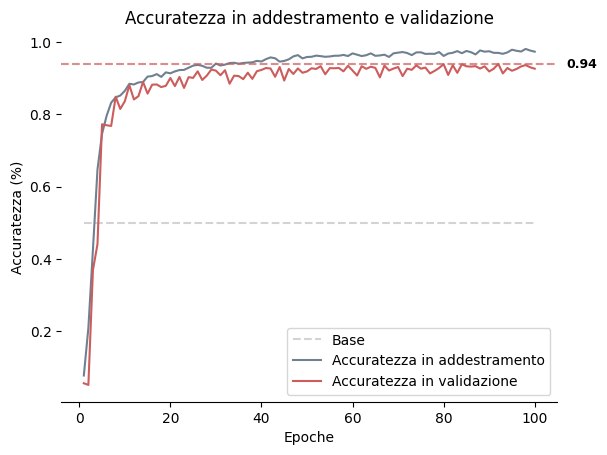

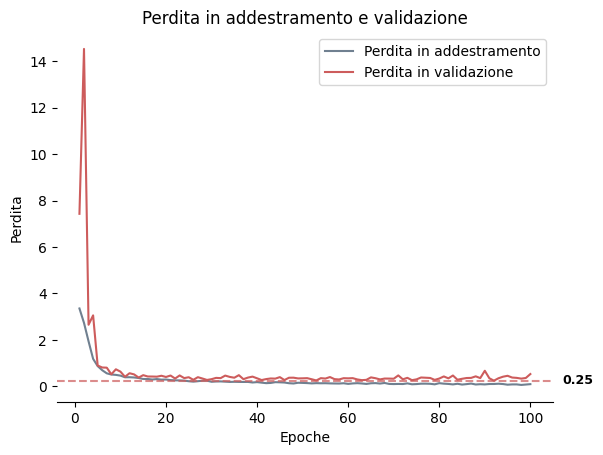

In [16]:
create_train_val_plot(history_voxprofunda.history, overfit=False)

Dal grafico notiamo che il modello non entra in overfitting, e raggiunge degli ottimi risultati fin da subito. La perdita ottenuta nella validazione è molto bassa, e l'accuratezza in fase di validazione è anch'essa la migliore mai ottenuta.

In [17]:
best_voxprofunda = tf.keras.models.load_model("bestmodels/resnet/voxprofunda_spect.keras")
test_loss, test_acc = best_voxprofunda.evaluate(spect_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 5s 41ms/step - loss: 0.3290 - accuracy: 0.9318
Accuratezza: 0.932


In [18]:
evaluate_onnx_model("bestmodels/resnet/voxprofunda_spect.onnx", spect_test_ds)

Accuratezza: 0.932


Abbiamo ottenuto un'accuratezza del **92.3%**!
Il modello ha impiegato 30 minuti a trainare con la GPU A100 con Ram Avanzata.

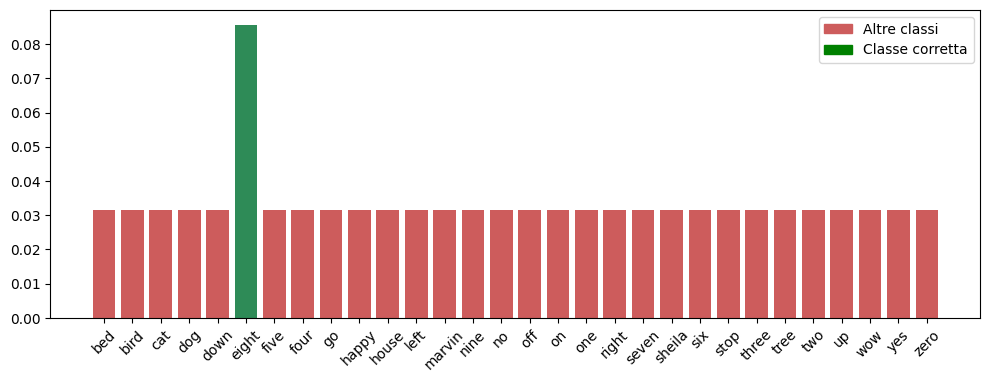

In [22]:
for audio, label in spect_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_voxprofunda, audio, label)
    break

## Addestramento VoxProfunda (Filter bank)
Procediamo ad addestrare lo stesso modello sui filter bank. Non ripeteremo alcuna spiegazione essendo un passaggio ormai noto.

In [23]:
fb_train_ds = DatasetConverter(train_ds)
fb_train_ds = fb_train_ds.convert('filterbanks')

fb_validation_ds = DatasetConverter(validation_ds)
fb_validation_ds = fb_validation_ds.convert('filterbanks')

fb_val_ds = fb_validation_ds.take(fb_validation_ds.cardinality() // 2)
fb_test_ds = fb_validation_ds.skip(fb_validation_ds.cardinality() // 2)

In [24]:
del voxprofunda

voxprofunda = VoxProfunda()

for audio, label in fb_train_ds:
    voxprofunda = voxprofunda.get_model(audio.shape[1:])
    break

voxprofunda.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

voxprofunda.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 98, 40, 1)]          0         []                            
                                                                                                  
 normalization (Normalizati  (None, 98, 40, 1)            3         ['input[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 49, 20, 64)           3456      ['normalization[0][0]']       
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 25, 10, 64)           0         ['conv1[0][0]']         

In [25]:
callback_voxprofunda = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/resnet/voxprofunda_fb.keras", save_best_only=True, monitor="val_loss")]
history_voxprofunda = voxprofunda.fit(fb_train_ds, epochs=100, validation_data=fb_val_ds, callbacks=callback_voxprofunda)

Epoch 1/100
243/243 [==============================] - 27s 45ms/step - loss: 5.9464 - accuracy: 0.0348 - val_loss: 3.4018 - val_accuracy: 0.0285
Epoch 2/100
243/243 [==============================] - 9s 36ms/step - loss: 3.3934 - accuracy: 0.0429 - val_loss: 3.3625 - val_accuracy: 0.0421
Epoch 3/100
243/243 [==============================] - 9s 36ms/step - loss: 3.3082 - accuracy: 0.0669 - val_loss: 3.2811 - val_accuracy: 0.0671
Epoch 4/100
243/243 [==============================] - 9s 36ms/step - loss: 3.1167 - accuracy: 0.1089 - val_loss: 3.2573 - val_accuracy: 0.0814
Epoch 5/100
243/243 [==============================] - 7s 30ms/step - loss: 2.7548 - accuracy: 0.1981 - val_loss: 4.5284 - val_accuracy: 0.0721
Epoch 6/100
243/243 [==============================] - 9s 36ms/step - loss: 1.9312 - accuracy: 0.4309 - val_loss: 2.6477 - val_accuracy: 0.2261
Epoch 7/100
243/243 [==============================] - 9s 36ms/step - loss: 1.2467 - accuracy: 0.6332 - val_loss: 1.5987 - val_accuracy

In [26]:
voxprofunda_df = convert_history_to_csv(history_voxprofunda)
voxprofunda_df.to_csv("model_histories/resnet/voxprofunda_fb.csv")

convert_model_to_onnx("bestmodels/resnet/voxprofunda_fb.keras", (98, 40, 1))

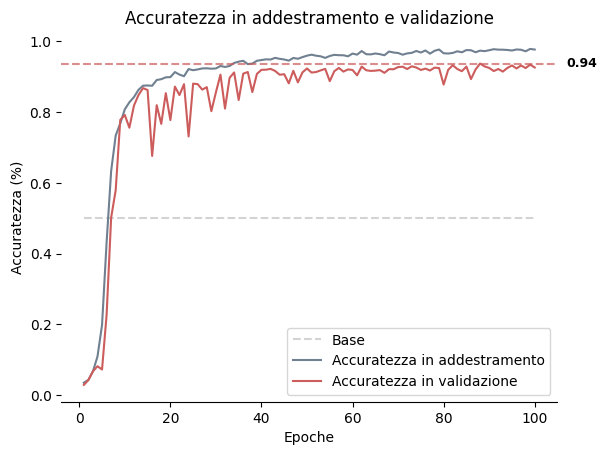

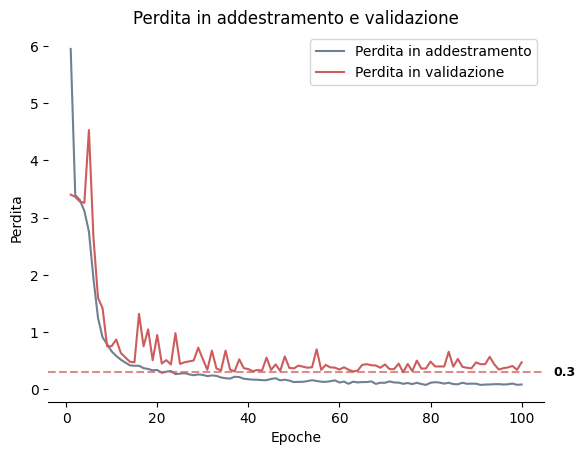

In [28]:
create_train_val_plot(history_voxprofunda.history, overfit=False)

Dal grafico notiamo che il modello non entra in overfitting, e raggiunge degli ottimi risultati fin da subito. La perdita ottenuta nella validazione è molto bassa, e l'accuratezza in fase di validazione è anch'essa la migliore mai ottenuta.

In [29]:
best_voxprofunda = tf.keras.models.load_model("bestmodels/resnet/voxprofunda_fb.keras")
test_loss, test_acc = best_voxprofunda.evaluate(fb_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 16ms/step - loss: 0.3503 - accuracy: 0.9171
Accuratezza: 0.917


In [30]:
evaluate_onnx_model("bestmodels/resnet/voxprofunda_fb.onnx", fb_test_ds)

Accuratezza: 0.917


Abbiamo ottenuto un'accuratezza del **91.7%**! Leggermente più bassa rispetto alla precedente. 

Il modello ha impiegato 13 minuti a trainare con la GPU A100 con Ram Avanzata.

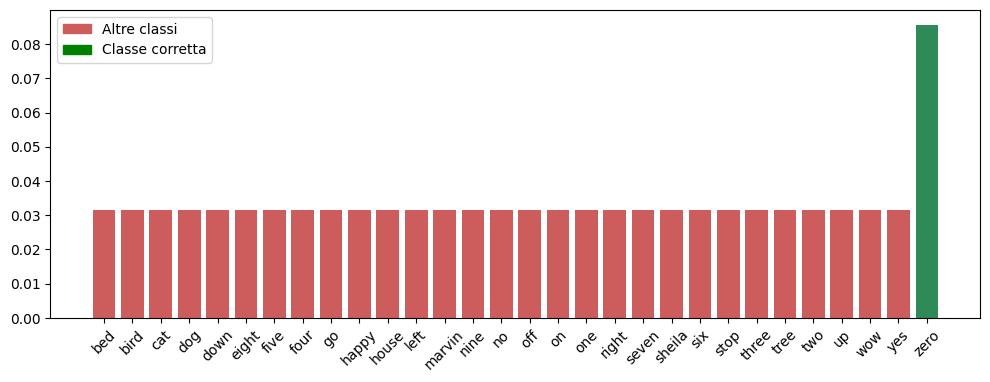

In [32]:
for audio, label in fb_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_voxprofunda, audio, label)
    break

## Addestramento VoxProfunda (MFCC)
Infine ripetiamo il procedimento per gli MFCC

In [33]:
mfcc_train_ds = DatasetConverter(train_ds)
mfcc_train_ds = mfcc_train_ds.convert('mfcc')

mfcc_validation_ds = DatasetConverter(validation_ds)
mfcc_validation_ds = mfcc_validation_ds.convert('mfcc')

mfcc_val_ds = mfcc_validation_ds.take(mfcc_validation_ds.cardinality() // 2)
mfcc_test_ds = mfcc_validation_ds.skip(mfcc_validation_ds.cardinality() // 2)

In [34]:
del voxprofunda

voxprofunda = VoxProfunda()

for audio, label in mfcc_train_ds:
    voxprofunda = voxprofunda.get_model(audio.shape[1:])
    break

voxprofunda.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

voxprofunda.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 98, 12, 1)]          0         []                            
                                                                                                  
 normalization (Normalizati  (None, 98, 12, 1)            3         ['input[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 49, 6, 64)            3456      ['normalization[0][0]']       
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 25, 3, 64)            0         ['conv1[0][0]']         

In [35]:
callback_voxprofunda = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/resnet/voxprofunda_mfcc.keras", save_best_only=True, monitor="val_loss")]
history_voxprofunda = voxprofunda.fit(mfcc_train_ds, epochs=100, validation_data=mfcc_val_ds, callbacks=callback_voxprofunda)

Epoch 1/100
243/243 [==============================] - 24s 37ms/step - loss: 4.3268 - accuracy: 0.1115 - val_loss: 4.7682 - val_accuracy: 0.1636
Epoch 2/100
243/243 [==============================] - 6s 25ms/step - loss: 2.2094 - accuracy: 0.3610 - val_loss: 7.2337 - val_accuracy: 0.2022
Epoch 3/100
243/243 [==============================] - 6s 25ms/step - loss: 1.4843 - accuracy: 0.5644 - val_loss: 4.9320 - val_accuracy: 0.3600
Epoch 4/100
243/243 [==============================] - 6s 26ms/step - loss: 1.1209 - accuracy: 0.6764 - val_loss: 7.7811 - val_accuracy: 0.3002
Epoch 5/100
243/243 [==============================] - 8s 31ms/step - loss: 0.9716 - accuracy: 0.7159 - val_loss: 1.8096 - val_accuracy: 0.6246
Epoch 6/100
243/243 [==============================] - 8s 32ms/step - loss: 0.8546 - accuracy: 0.7491 - val_loss: 1.2360 - val_accuracy: 0.6809
Epoch 7/100
243/243 [==============================] - 6s 26ms/step - loss: 0.8407 - accuracy: 0.7567 - val_loss: 1.6921 - val_accuracy

In [36]:
voxprofunda_df = convert_history_to_csv(history_voxprofunda)
voxprofunda_df.to_csv("model_histories/resnet/voxprofunda_mfcc.csv")

convert_model_to_onnx("bestmodels/resnet/voxprofunda_mfcc.keras", (98, 12, 1))

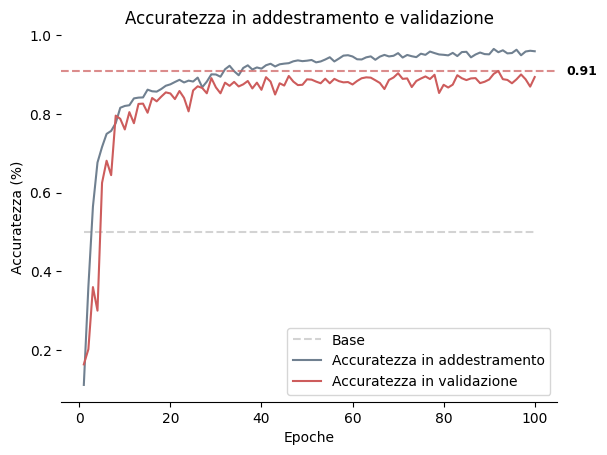

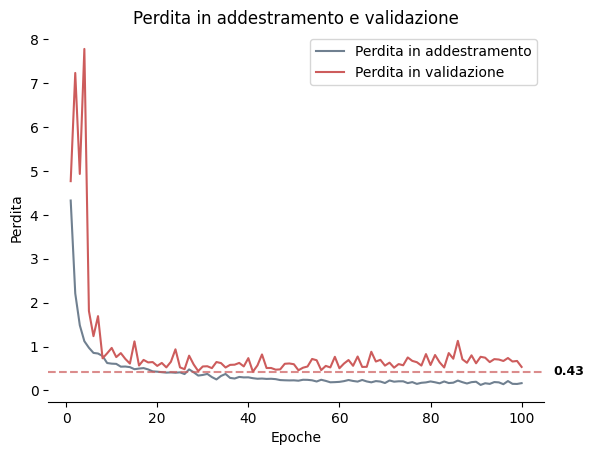

In [39]:
create_train_val_plot(history_voxprofunda.history, overfit=False)

Dal grafico notiamo che il modello non entra in overfitting, e raggiunge degli ottimi risultati fin da subito. La perdita ottenuta nella validazione è molto bassa, e l'accuratezza in fase di validazione è anch'essa la migliore mai ottenuta.

In [40]:
best_voxprofunda = tf.keras.models.load_model("bestmodels/resnet/voxprofunda_mfcc.keras")
test_loss, test_acc = best_voxprofunda.evaluate(mfcc_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 10ms/step - loss: 0.4010 - accuracy: 0.8822
Accuratezza: 0.882


In [41]:
evaluate_onnx_model("bestmodels/resnet/voxprofunda_mfcc.onnx", mfcc_test_ds)

Accuratezza: 0.882


Abbiamo ottenuto un'accuratezza del **88.2%**! Come notato per gli altri modelli convolutivi, questo tipo di dati non fanno performare bene i modelli quanto gli altri e lo stesso vale per la nostra voxProfunda.

Il modello ha impiegato 13 minuti a trainare con la GPU A100 con Ram Avanzata.

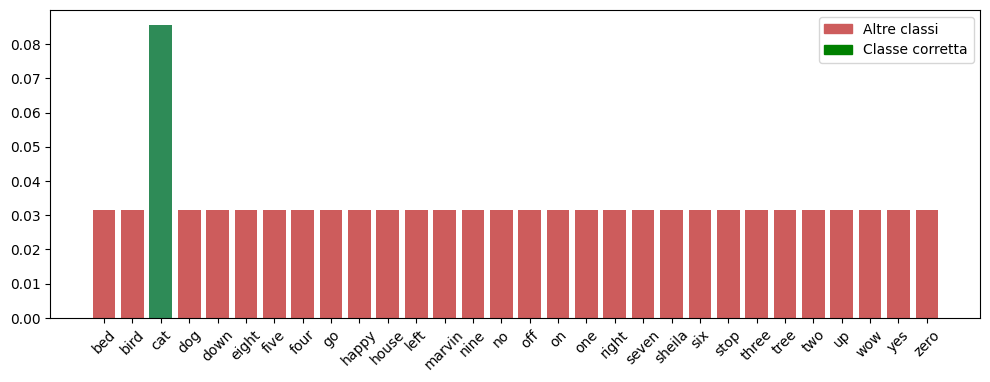

In [42]:
for audio, label in mfcc_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_voxprofunda, audio, label)
    break